In [73]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
import chess.pgn
from stockfish import Stockfish
import sqlite3
import chess
import graphviz
import chess.polyglot
import torch.autograd as autograd
import torch.nn.functional as F

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.MSELoss()

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(6, 24, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 96, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(96, 384, 2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(384, 1)
        )
    def forward(self, x):
        return self.layers(x)

In [4]:
model = Model()
# model = torch.load("abc.pt")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

Model(
  (layers): Sequential(
    (0): Conv2d(6, 24, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 96, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(96, 384, kernel_size=(2, 2), stride=(2, 2))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=384, out_features=1, bias=True)
  )
)

In [13]:
def fen_to_bitboard(fen):
    f = torch.zeros((6, 64))
    board = chess.Board(fen)
    
    f[0][list(board.pieces(chess.PAWN, chess.WHITE))] = 1
    f[1][list(board.pieces(chess.KNIGHT, chess.WHITE))] = 1
    f[2][list(board.pieces(chess.BISHOP, chess.WHITE))] = 1
    f[3][list(board.pieces(chess.ROOK, chess.WHITE))] = 1
    f[4][list(board.pieces(chess.QUEEN, chess.WHITE))] = 1
    f[5][list(board.pieces(chess.KING, chess.WHITE))] = 1
    
    f[0][list(board.pieces(chess.PAWN, chess.BLACK))] = -1
    f[1][list(board.pieces(chess.KNIGHT, chess.BLACK))] = -1
    f[2][list(board.pieces(chess.BISHOP, chess.BLACK))] = -1
    f[3][list(board.pieces(chess.ROOK, chess.BLACK))] = -1
    f[4][list(board.pieces(chess.QUEEN, chess.BLACK))] = -1
    f[5][list(board.pieces(chess.KING, chess.BLACK))] = -1
    
    return f.view(1, 6, 64)

In [14]:
con = sqlite3.connect('test.db')
cur = con.cursor()

In [15]:
def transform(evaluation, fen):
    board = chess.Board(fen)
#     if board.turn == chess.WHITE:
    return (np.arctan(1/2 * evaluation) + np.pi/2)/(np.pi)
#     else:
#         return 1 - ((np.arctan(1/2 * evaluation) + np.pi/2)/(np.pi))
    

In [9]:
size = 1000000
# training dataset
fens_ = cur.execute(f"SELECT fen FROM evaluations LIMIT {size}")
fens = fens_.fetchall()
# board = chess.Board()
tensors = []
tensors = [fen_to_bitboard(fens[i][0]) for i in range(size)]
bits = torch.cat(tensors, dim=0)
with open('cnn_examples.npy', 'wb') as f:
    np.save(f, bits)

# evals_ = cur.execute(f"SELECT eval FROM evaluations LIMIT {size}")
# evals = evals_.fetchall()
# temp = [transform(evals[i][0], fens[i][0]) for i in range(size)]
# evaluations = torch.tensor(temp, dtype=torch.float32)
# with open('cnn_labels.npy', 'wb') as f:
#     np.save(f, evaluations)


# evaluation dataset
# eval_size = 10000
# e_fen_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > {size} LIMIT {eval_size}")
# e_fen = e_fen_.fetchall()
# tensors = [fen_to_bitboard(e_fen[i][0]) for i in range(eval_size)]
# bits = torch.cat(tensors, dim=0)
# with open('eval_examples.npy', 'wb') as f:
#     np.save(f, bits)

# evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id > {size} LIMIT {eval_size}")
# evaluation = evaluation_.fetchall()
# temp = [((np.arctan(1/2 * evaluation[i][0]) + np.pi/2)/(np.pi)) for i in range(eval_size)]
# evaluations = torch.tensor(temp)
# with open('eval_labels.npy', 'wb') as f:
#     np.save(f, evaluations)

# plt.style.use('_mpl-gallery')

# # make data
# np.random.seed(1)

# # plot:
# fig, ax = plt.subplots()

# ax.hist(x, bins=100, linewidth=0.5, edgecolor="white")

# ax.set(xlim=(-2, 2), xticks=np.arange(1, 1),
#        ylim=(0, 1000), yticks=np.linspace(0, 1000, 9))

# plt.show()

In [5]:
losses = []
# eval_losses = []

bits = torch.from_numpy(np.load("cnn_examples.npy")).to(device)
labels = torch.from_numpy(np.load("cnn_labels.npy")).to(device)

# eval_examples = torch.from_numpy(np.load("eval_examples.npy")).to(device)
# eval_labels = torch.from_numpy(np.load("eval_labels.npy")).to(device)

In [6]:
# model training
# https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
n_epochs = 100 # or whatever
batch_size = 128 # or whatever

for epoch in range(n_epochs):
    # X is a torch Variable
    permutation = torch.randperm(bits.size()[0])
#     eval_permutation = torch.randperm(bits.size()[0])
#     for i in range(0, eval_examples.size()[0], batch_size):
#         indices = eval_permutation[i:i+batch_size]
#         batch_x, batch_y = bits[indices], labels[indices]
#         outputs = model(batch_x)
        
#         loss = loss_function(outputs, batch_y.view(-1, 1))
#         eval_losses.append(loss.item())
        
    for i in range(0, bits.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = bits[indices], labels[indices]
        
        outputs = model(batch_x.view(-1, 6, 8, 8))
        loss = loss_function(outputs, batch_y.view(-1, 1))
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

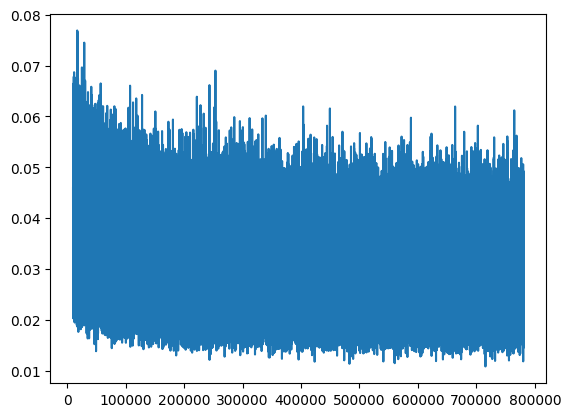

In [7]:
start = 10000
smooth = 1

x = np.arange(len(losses)/smooth)
y = torch.tensor(losses).view(smooth, -1).mean(0)
plt.plot(x[start:], y[start:])

# e_x = np.arange(0, (len(eval_losses)/smooth) * 100, 100)
# e_y = torch.tensor(eval_losses).view(smooth, -1).mean(0)
# plt.plot(e_x[int(start/100):], e_y[int(start/100):])

# plt.ylim(0, 0.5)
plt.show()

In [8]:
sum(losses[len(losses) - 100:]) / 100

0.028626808589324357

In [71]:
print(list(model.parameters())[6].shape)

torch.Size([1, 384])


tensor([0.9369]) tensor([0.7259])


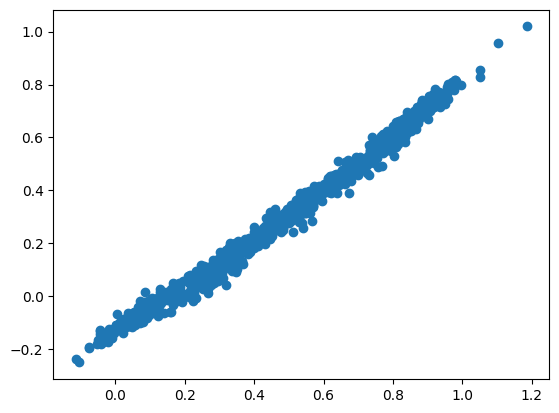

In [165]:
size = 1000
# training dataset
fens_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > 1000000 LIMIT {size}")
fens = fens_.fetchall()

# fig, ax = plt.subplots()

qmin = 0
qmax = 255

w = list(model.parameters())

w1 = w[0].detach().cpu()
w1_S = (w1.max() - w1.min()) / (qmax - qmin)
w1_Z = qmin - (w1.min() / w1_S)
q_w1 = (w1 / w1_S + w1_Z).clamp(qmin, qmax).round()

b1 = w[1].detach().cpu()
q_b1 = (b1/w1_S + w1_Z).clamp(qmin, qmax).round() # this clamping doesn't do anything :)

w2 = w[2].detach().cpu()
w2_S = (w2.max() - w2.min()) / (qmax - qmin)
w2_Z = qmin - (w2.min() / w2_S)
q_w2 = (w2 / w2_S + w2_Z).clamp(qmin, qmax).round()

b2 = w[3].detach().cpu()
q_b2 = (b2/w2_S + w2_Z).clamp(qmin, qmax).round()

w3 = w[4].detach().cpu()
w3_S = (w3.max() - w3.min()) / (qmax - qmin)
w3_Z = qmin - (w3.min() / w3_S)
q_w3 = (w3 / w3_S + w3_Z).clamp(qmin, qmax).round()

b3 = w[5].detach().cpu()
q_b3 = (b3/w3_S + w3_Z).clamp(qmin, qmax).round()

w4 = w[6].detach().cpu()
w4_S = (w4.max() - w4.min()) / (qmax - qmin)
w4_Z = qmin - (w4.min() / w4_S)
q_w4 = (w4 / w4_S + w4_Z).clamp(qmin, qmax).round()

b4 = w[7].detach().cpu()
q_b4 = (b4/w4_S + w4_Z).clamp(qmin, qmax).round()

relu = nn.ReLU()
# L = []
# for i in w1.int():
#     L.append(i.item())
# print(L)
real = []
quant = []
# quants = 0
# quantz = 0
for i in range(1000):
#     fen = "rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1"
    fen = fens[i][0]
    a = fen_to_bitboard(fen).view(1, 6, 8, 8)
    
#     # real
    r = F.conv2d(a, w1, stride=2) + b1.view(1, 24, 1, 1)
    r = relu(r)
    r = F.conv2d(r, w2, stride=2) + b2.view(1, 96, 1, 1)
    r = relu(r)
    r = F.conv2d(r, w3, stride=2) + b3.view(1, 384, 1, 1)
    r = relu(r)
    r = torch.flatten(r)
    r = (r @ w4.T) + b4

#     # quantb
    q = (F.conv2d(a, (q_w1 - w1_Z), stride=2) + (q_b1.view(1, 24, 1, 1) - w1_Z)) * w1_S
    q = relu(q)
    q = (F.conv2d(q, (q_w2 - w2_Z), stride=2) + (q_b2.view(1, 96, 1, 1) - w2_Z)) * w2_S
    q = relu(q)
    q = (F.conv2d(q, (q_w3 - w3_Z), stride=2) + (q_b3.view(1, 384, 1, 1) - w3_Z)) * w3_S 
    q = relu(q)
    q = torch.flatten(q)
    q = ((q @ (q_w4.T - w4_Z)) + (q_b4 - w4_Z)) * w4_S
    
    real.append(r.item())
    quant.append(q.item())
#     quants += -torch.min(q)+torch.max(q)
#     quantz += (torch.min(q)+torch.max(q))/2
plt.scatter(real, quant);
# print(q_w2.T)
# plt.hist(w1.view(1, -1), 100);
# print(quants/1000)
# print(quantz/1000)
print(f'{r} {q}')

# print(w3_Z.item())
# for i in b3:
#     print(i.item(), end=", ")

In [105]:
for row in range(q_w1.T.shape[0]):
    for col in range(q_w1.T.shape[1]):
        print(q_w1.T[row, col].item(), end=", ")
    print()

131.0, 123.0, 135.0, 132.0, 127.0, 130.0, 131.0, 136.0, 127.0, 132.0, 141.0, 135.0, 145.0, 141.0, 123.0, 128.0, 
121.0, 135.0, 139.0, 114.0, 126.0, 129.0, 130.0, 127.0, 127.0, 127.0, 147.0, 146.0, 138.0, 140.0, 132.0, 133.0, 
125.0, 135.0, 137.0, 128.0, 139.0, 129.0, 136.0, 135.0, 123.0, 135.0, 139.0, 128.0, 138.0, 122.0, 134.0, 127.0, 
138.0, 125.0, 130.0, 132.0, 131.0, 125.0, 130.0, 141.0, 134.0, 142.0, 133.0, 126.0, 129.0, 135.0, 145.0, 130.0, 
133.0, 134.0, 130.0, 135.0, 132.0, 135.0, 134.0, 136.0, 138.0, 133.0, 138.0, 141.0, 141.0, 127.0, 120.0, 131.0, 
122.0, 137.0, 128.0, 136.0, 147.0, 132.0, 134.0, 148.0, 116.0, 121.0, 130.0, 135.0, 143.0, 128.0, 145.0, 130.0, 
120.0, 119.0, 145.0, 133.0, 143.0, 146.0, 141.0, 134.0, 138.0, 129.0, 123.0, 119.0, 120.0, 141.0, 130.0, 131.0, 
140.0, 129.0, 142.0, 126.0, 141.0, 137.0, 123.0, 118.0, 128.0, 125.0, 141.0, 149.0, 130.0, 130.0, 122.0, 142.0, 
130.0, 85.0, 139.0, 138.0, 96.0, 153.0, 132.0, 133.0, 137.0, 145.0, 138.0, 141.0, 113.0, 128.0, 

In [69]:
for row in range(q_w1.T.shape[0]//4):
    for col in range(q_w1.T.shape[1]//4):
        print(q_w1.T[row*4:row*4+4, col*4:col*4+4])
#     print()

tensor([[131., 123., 135., 132.],
        [121., 135., 139., 114.],
        [125., 135., 137., 128.],
        [138., 125., 130., 132.]])
tensor([[127., 130., 131., 136.],
        [126., 129., 130., 127.],
        [139., 129., 136., 135.],
        [131., 125., 130., 141.]])
tensor([[127., 132., 141., 135.],
        [127., 127., 147., 146.],
        [123., 135., 139., 128.],
        [134., 142., 133., 126.]])
tensor([[145., 141., 123., 128.],
        [138., 140., 132., 133.],
        [138., 122., 134., 127.],
        [129., 135., 145., 130.]])
tensor([[133., 134., 130., 135.],
        [122., 137., 128., 136.],
        [120., 119., 145., 133.],
        [140., 129., 142., 126.]])
tensor([[132., 135., 134., 136.],
        [147., 132., 134., 148.],
        [143., 146., 141., 134.],
        [141., 137., 123., 118.]])
tensor([[138., 133., 138., 141.],
        [116., 121., 130., 135.],
        [138., 129., 123., 119.],
        [128., 125., 141., 149.]])
tensor([[141., 127., 120., 131.],
       

In [117]:
def quant_evaluation(a):
    qmin = 0
    qmax = 255
    
    relu = nn.ReLU()
    
    w = list(model.parameters())

    w1 = w[0].detach().cpu()
    w1_S = (w1.max() - w1.min()) / (qmax - qmin)
    w1_Z = qmin - (w1.min() / w1_S)
    q_w1 = (w1 / w1_S + w1_Z).clamp(qmin, qmax).round()

    b1 = w[1].detach().cpu()

    w2 = w[2].detach().cpu()
    w2_S = (w2.max() - w2.min()) / (qmax - qmin)
    w2_Z = qmin - (w2.min() / w2_S)
    q_w2 = (w2 / w2_S + w2_Z).clamp(qmin, qmax).round()

    b2 = w[3].detach().cpu()

    w3 = w[4].detach().cpu()
    w3_S = (w3.max() - w3.min()) / (qmax - qmin)
    w3_Z = qmin - (w3.min() / w3_S)
    q_w3 = (w3 / w3_S + w3_Z).clamp(qmin, qmax).round()

    b3 = w[5].detach().cpu()

#     # quantb
    q = (a @ (q_w1.T - w1_Z))
#     q = relu(q)
#     q = (q @ (q_w2.T - w2_Z) * w2_S) + b2
#     q = relu(q)
#     q = (q @ (q_w3.T - w3_Z) * w3_S) + b3
    return q

In [119]:
'{0:04b}'.format(15)

'1111'

In [101]:
temp = torch.zeros((3, 16))
tempington = torch.cat((q_w3, temp), dim=0)

In [116]:
compressed = []
bits = 8
for row in range(q_w1.T.shape[0]//4):
    for col in range(q_w1.T.shape[1]//4):
        L = list([int(i.item()) for i in q_w1.T[row*4:row*4+4, col*4:col*4+4].flatten()])
        for param in range(int(len(L)/bits)):
            string = ""
            for number in L[param*8:param*8+8]:
                string += '{0:08b}'.format(number)
        #     print(string)
            compressed.append(int(string, 2))
print(len(compressed))

768


In [18]:
size = 1000000

# evaluation dataset
eval_size = 1000
e_fen_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > {size} LIMIT {eval_size}")
e_fen = e_fen_.fetchall()
tensors = [fen_to_bitboard(e_fen[i][0]) for i in range(eval_size)]
bits = torch.cat(tensors, dim=0)

evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id > {size} LIMIT {eval_size}")
evaluation = evaluation_.fetchall()
# temp = [((np.arctan(1/2 * evaluation[i][0]) + np.pi/2)/(np.pi)) for i in range(eval_size)]
temp = [transform(evaluation[i][0], e_fen[i][0]) for i in range(eval_size)]
evaluations = torch.tensor(temp)

model.eval()
losses = []

for i in range(eval_size):
    loss = loss_function(model(bits[i].view(-1, 6, 8, 8).to(device)).view(-1), evaluations[i].to(device).view(-1))
    losses.append(loss.item())
print(sum(losses) / len(losses))

0.04900935336216601


In [26]:
def evaluation(fen):
    model.eval()
    score  = model(fen_to_bitboard(fen).view(-1, 6, 8, 8).to(device))
    model.train()
    return score.item()

In [29]:
# pass all reachable board states to network
fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
board = chess.Board(fen)
moves = list(board.legal_moves)

scores = {}
best_score = -1000
best_move = ""
for m in moves:
    board.push(m)
    score = evaluation(board.fen())
    print(str(score) + " " + str(m))
    scores[m] = score
    board.pop()
# d_sorted = sorted(zip(scores.values(), scores.keys()))
# for i in d_sorted:
#     print(i)
# print(sum(scores) / len(scores))

0.4165940284729004 g1h3
0.48666638135910034 g1f3
0.49448758363723755 b1c3
0.39725974202156067 b1a3
0.4827471375465393 h2h3
0.46959471702575684 g2g3
0.3915138840675354 f2f3
0.46951067447662354 e2e3
0.45767742395401 d2d3
0.4565489888191223 c2c3
0.4388090968132019 b2b3
0.44283998012542725 a2a3
0.3653096556663513 h2h4
0.3895231783390045 g2g4
0.3755662143230438 f2f4
0.49780136346817017 e2e4
0.5083615779876709 d2d4
0.4941716492176056 c2c4
0.4354049563407898 b2b4
0.4327085316181183 a2a4


In [96]:
# pass fen to network
fen = "rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1"
print(evaluation(fen))

0.49780136346817017
